In [ ]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.optimizers import Adam

#import kerastuner as kt

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

import os

import time 

import math
import random

from datetime import datetime, date


import re

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from google.colab import drive



In [ ]:
!nvidia-smi

Sun Apr  4 22:27:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
gdrive_dir = '/content/gdrive/'

drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


# Read voter file into the notebook

In [ ]:
data_dir = os.path.join(gdrive_dir, "My Drive", "homeless coalition", 'trust fund campaign')

filename = 'voter file features collected.csv'

voter_file = pd.read_csv(os.path.join(data_dir, filename))

In [ ]:
voter_file.shape

(223469, 126)

In [ ]:
voter_file.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,PARTY_AFFILIATION,RESIDENTIAL_ADDRESS1_voter,RESIDENTIAL_SECONDARY_ADDR,RESIDENTIAL_CITY_voter,RESIDENTIAL_STATE_voter,RESIDENTIAL_ZIP_voter,RESIDENTIAL_ZIP_PLUS4,RESIDENTIAL_COUNTRY,RESIDENTIAL_POSTALCODE,tigerlineid,side,tract,block,lat,lon,MAILING_ADDRESS1,MAILING_SECONDARY_ADDRESS,MAILING_CITY,MAILING_STATE,MAILING_ZIP,MAILING_ZIP_PLUS4,MAILING_COUNTRY,MAILING_POSTAL_CODE,CAREER_CENTER,CITY,CITY_SCHOOL_DISTRICT,COUNTY_COURT_DISTRICT,CONGRESSIONAL_DISTRICT,COURT_OF_APPEALS,EDU_SERVICE_CENTER_DISTRICT,EXEMPTED_VILL_SCHOOL_DISTRICT,LIBRARY,LOCAL_SCHOOL_DISTRICT,MUNICIPAL_COURT_DISTRICT,PRECINCT_NAME,PRECINCT_CODE,STATE_BOARD_OF_EDUCATION,STATE_REPRESENTATIVE_DISTRICT,STATE_SENATE_DISTRICT,TOWNSHIP,VILLAGE,WARD,PRIMARY-03/07/2000,GENERAL-11/07/2000,SPECIAL-05/08/2001,GENERAL-11/06/2001,PRIMARY-05/07/2002,GENERAL-11/05/2002,SPECIAL-05/06/2003,GENERAL-11/04/2003,PRIMARY-03/02/2004,GENERAL-11/02/2004,SPECIAL-02/08/2005,PRIMARY-05/03/2005,PRIMARY-09/13/2005,GENERAL-11/08/2005,SPECIAL-02/07/2006,PRIMARY-05/02/2006,GENERAL-11/07/2006,PRIMARY-05/08/2007,PRIMARY-09/11/2007,GENERAL-11/06/2007,PRIMARY-11/06/2007,GENERAL-12/11/2007,PRIMARY-03/04/2008,PRIMARY-10/14/2008,GENERAL-11/04/2008,GENERAL-11/18/2008,PRIMARY-05/05/2009,PRIMARY-09/08/2009,PRIMARY-09/15/2009,PRIMARY-09/29/2009,GENERAL-11/03/2009,PRIMARY-05/04/2010,PRIMARY-07/13/2010,PRIMARY-09/07/2010,GENERAL-11/02/2010,PRIMARY-05/03/2011,PRIMARY-09/13/2011,GENERAL-11/08/2011,PRIMARY-03/06/2012,GENERAL-11/06/2012,PRIMARY-05/07/2013,PRIMARY-09/10/2013,PRIMARY-10/01/2013,GENERAL-11/05/2013,PRIMARY-05/06/2014,GENERAL-11/04/2014,PRIMARY-05/05/2015,PRIMARY-09/15/2015,GENERAL-11/03/2015,PRIMARY-03/15/2016,GENERAL-06/07/2016,PRIMARY-09/13/2016,GENERAL-11/08/2016,PRIMARY-05/02/2017,PRIMARY-09/12/2017,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019,PRIMARY-03/17/2020,GENERAL-11/03/2020,block_str,fips_bg,census_block_number,race_name,GENDER,pct_under_30k,pct_post_grad,pct_renters,is_apartment,FIRST_ELIGIBLE_ELECTION
0,OH0023466264,31,1884306,POKORNY,MICHAEL,F,NaN,1987-07-19,2015-12-22,ACTIVE,NaN,526 LIBERTY HILL,NaN,CINCINNATI,OH,45202,NaN,NaN,NaN,103953039.0,L,1800.0,1017.0,39.112280,-84.505615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 10-A,31-AGY,4,32,9,NaN,NaN,CINTI WARD 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,X,1017,390610018001,390610018001017,white,male,0.124260,0.272593,0.568047,0,PRIMARY-03/15/2016
1,OH0023768498,31,1907972,SCARBOROUGH,ANTHONY,M,NaN,1968-08-24,2016-06-27,CONFIRMATION,NaN,1022 YALE AVE,NaN,CINCINNATI,OH,45206,NaN,NaN,NaN,103970492.0,L,3700.0,1005.0,39.128967,-84.487260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 9-D,31-AGQ,4,31,9,NaN,NaN,CINTI WARD 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1005,390610037001,390610037001005,white,male,0.413636,0.061789,0.636364,0,PRIMARY-09/13/2016
2,OH0019612471,31,1617057,ROEHM,PAMELA,JEAN,NaN,1964-10-11,2007-12-07,ACTIVE,NaN,7100 EASTLAWN DR,APT 1,CINCINNATI,OH,45237,NaN,NaN,NaN,650379265.0,R,27100.0,2000.0,39.189327,-84.456894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 7-B,31-AFG,4,33,9,NaN,NaN,CINTI WARD 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
voter_file['DATE_OF_BIRTH'] = pd.to_datetime(voter_file['DATE_OF_BIRTH'], format="%Y-%m-%d")
voter_file['DATE_OF_BIRTH'] = voter_file['DATE_OF_BIRTH'].dt.date

voter_file['REGISTRATION_DATE'] = pd.to_datetime(voter_file['REGISTRATION_DATE'], format="%Y-%m-%d")
voter_file['REGISTRATION_DATE'] = voter_file['REGISTRATION_DATE'].dt.date

# Data Cleaning 
* delete people born in 1800

In [ ]:
dead_people_indices = voter_file.index[voter_file['DATE_OF_BIRTH'] == date(year=1800, month=1, day=1)]

In [ ]:
dead_people_indices

Int64Index([  6372,  14799,  18664,  19107,  21018,  22004,  25480,  29031,
             30294,  33951,  35823,  41593,  43532,  44800,  47705,  48442,
             52041,  53051,  53792,  58376,  61964,  67888,  72251,  72975,
             80114,  88232,  90105,  91667,  98678,  99149, 101158, 103386,
            107138, 110419, 111774, 112368, 113735, 117732, 120312, 120347,
            121859, 122477, 123800, 135938, 138009, 140814, 144782, 147226,
            155210, 159578, 160339, 160340, 169929, 172396, 178584, 179081,
            188612, 190218, 196511, 196675, 199700, 202953, 210515, 211377,
            216247],
           dtype='int64')

In [ ]:
voter_file.drop(dead_people_indices, inplace=True)

In [ ]:
voter_file.index[voter_file['DATE_OF_BIRTH'] == date(year=1800, month=1, day=1)].shape

(0,)

In [ ]:
voter_file.shape

(223404, 126)

# Calculate Age, Years Registered


In [ ]:
election_date = date(year=2021,month=5,day=4)

In [ ]:
voter_file['AGE'] = voter_file['DATE_OF_BIRTH'].apply(lambda x: (election_date - x).days/365.25)

voter_file['YEARS_REGISTERED'] = voter_file['REGISTRATION_DATE'].apply(lambda x: (date.today() - x).days/365.25)

# In model building, need to remove folks registered after the election.
# In prediction, we can skip this part

In [ ]:
#get rid of people who registered on or after the election date
too_late_index = voter_file.index[voter_file['REGISTRATION_DATE'] >= election_date]

In [ ]:
voter_file.drop(too_late_index, inplace=True)

In [ ]:
voter_file[voter_file['REGISTRATION_DATE'] == election_date].shape

(0, 128)

# When model building, use the "model_build" functions.
# When predicting, use the "prediction" functions

In [ ]:
def primary_elections_turnout_model_build(row, var_election_cols, current_election_str):
    if pd.isna(row['FIRST_ELIGIBLE_ELECTION']) == True:
        return 0
    
    if row['FIRST_ELIGIBLE_ELECTION'] == current_election_str:
        return 0
    
    total_eligible_elections = var_election_cols[var_election_cols.index(row['FIRST_ELIGIBLE_ELECTION']):]
    primary_eligible_elections = [col_name for col_name in total_eligible_elections if col_name.find("PRIMARY") != -1]
    
    if len(primary_eligible_elections) == 0:
        return 0
    
    ballots_cast = 0

    for col_name in primary_eligible_elections:
        if pd.notna(row[col_name]) == True:
            ballots_cast += 1

    return ballots_cast/len(primary_eligible_elections)

In [ ]:
def total_elections_turnout_model_build(row, var_election_cols, current_election_str):
    
    if pd.isna(row['FIRST_ELIGIBLE_ELECTION']) == True:
        return 0
    
    if row['FIRST_ELIGIBLE_ELECTION'] == current_election_str or row['FIRST_ELIGIBLE_ELECTION'] == 'upcoming':
        return 0
    
    eligible_elections = var_election_cols[var_election_cols.index(row['FIRST_ELIGIBLE_ELECTION']):]

    ballots_cast = 0

    for col_name in eligible_elections:
        if pd.notna(row[col_name]) == True:
            ballots_cast += 1

    return ballots_cast/len(eligible_elections)


# Make sure the current election isn't in the calculation when model builing

In [ ]:
election_col_words = ['GENERAL', 'PRIMARY', 'SPECIAL']

election_cols = [name for name in voter_file.columns if name.split('-')[0] in election_col_words]

proxy_election_cols = [col_name for col_name in election_cols if datetime.strptime(col_name.split('-')[-1],"%m/%d/%Y").date() < election_date]

In [ ]:
proxy_election_str = "PRIMARY-03/17/2020"
voter_file['PCT_TOTAL_BALLOTS_CAST'] = voter_file.apply(total_elections_turnout_model_build, var_election_cols=proxy_election_cols, current_election_str = proxy_election_str, axis=1)


In [ ]:
voter_file['PCT_PRIMARY_BALLOTS_CAST'] = voter_file.apply(primary_elections_turnout_model_build, var_election_cols=proxy_election_cols, current_election_str = proxy_election_str, axis=1) 

In [ ]:
voter_file.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,PARTY_AFFILIATION,RESIDENTIAL_ADDRESS1_voter,RESIDENTIAL_SECONDARY_ADDR,RESIDENTIAL_CITY_voter,RESIDENTIAL_STATE_voter,RESIDENTIAL_ZIP_voter,RESIDENTIAL_ZIP_PLUS4,RESIDENTIAL_COUNTRY,RESIDENTIAL_POSTALCODE,tigerlineid,side,tract,block,lat,lon,MAILING_ADDRESS1,MAILING_SECONDARY_ADDRESS,MAILING_CITY,MAILING_STATE,MAILING_ZIP,MAILING_ZIP_PLUS4,MAILING_COUNTRY,MAILING_POSTAL_CODE,CAREER_CENTER,CITY,CITY_SCHOOL_DISTRICT,COUNTY_COURT_DISTRICT,CONGRESSIONAL_DISTRICT,COURT_OF_APPEALS,EDU_SERVICE_CENTER_DISTRICT,EXEMPTED_VILL_SCHOOL_DISTRICT,LIBRARY,LOCAL_SCHOOL_DISTRICT,MUNICIPAL_COURT_DISTRICT,PRECINCT_NAME,PRECINCT_CODE,STATE_BOARD_OF_EDUCATION,STATE_REPRESENTATIVE_DISTRICT,STATE_SENATE_DISTRICT,TOWNSHIP,VILLAGE,WARD,PRIMARY-03/07/2000,GENERAL-11/07/2000,SPECIAL-05/08/2001,GENERAL-11/06/2001,PRIMARY-05/07/2002,GENERAL-11/05/2002,SPECIAL-05/06/2003,GENERAL-11/04/2003,PRIMARY-03/02/2004,GENERAL-11/02/2004,SPECIAL-02/08/2005,PRIMARY-05/03/2005,PRIMARY-09/13/2005,GENERAL-11/08/2005,SPECIAL-02/07/2006,PRIMARY-05/02/2006,GENERAL-11/07/2006,PRIMARY-05/08/2007,PRIMARY-09/11/2007,GENERAL-11/06/2007,PRIMARY-11/06/2007,GENERAL-12/11/2007,PRIMARY-03/04/2008,PRIMARY-10/14/2008,GENERAL-11/04/2008,GENERAL-11/18/2008,PRIMARY-05/05/2009,PRIMARY-09/08/2009,PRIMARY-09/15/2009,PRIMARY-09/29/2009,GENERAL-11/03/2009,PRIMARY-05/04/2010,PRIMARY-07/13/2010,PRIMARY-09/07/2010,GENERAL-11/02/2010,PRIMARY-05/03/2011,PRIMARY-09/13/2011,GENERAL-11/08/2011,PRIMARY-03/06/2012,GENERAL-11/06/2012,PRIMARY-05/07/2013,PRIMARY-09/10/2013,PRIMARY-10/01/2013,GENERAL-11/05/2013,PRIMARY-05/06/2014,GENERAL-11/04/2014,PRIMARY-05/05/2015,PRIMARY-09/15/2015,GENERAL-11/03/2015,PRIMARY-03/15/2016,GENERAL-06/07/2016,PRIMARY-09/13/2016,GENERAL-11/08/2016,PRIMARY-05/02/2017,PRIMARY-09/12/2017,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019,PRIMARY-03/17/2020,GENERAL-11/03/2020,block_str,fips_bg,census_block_number,race_name,GENDER,pct_under_30k,pct_post_grad,pct_renters,is_apartment,FIRST_ELIGIBLE_ELECTION,AGE,YEARS_REGISTERED,PCT_TOTAL_BALLOTS_CAST,PCT_PRIMARY_BALLOTS_CAST
0,OH0023466264,31,1884306,POKORNY,MICHAEL,F,NaN,1987-07-19,2015-12-22,ACTIVE,NaN,526 LIBERTY HILL,NaN,CINCINNATI,OH,45202,NaN,NaN,NaN,103953039.0,L,1800.0,1017.0,39.112280,-84.505615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 10-A,31-AGY,4,32,9,NaN,NaN,CINTI WARD 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,X,1017,390610018001,390610018001017,white,male,0.124260,0.272593,0.568047,0,PRIMARY-03/15/2016,32.662560,5.278576,0.153846,0.000000
1,OH0023768498,31,1907972,SCARBOROUGH,ANTHONY,M,NaN,1968-08-24,2016-06-27,CONFIRMATION,NaN,1022 YALE AVE,NaN,CINCINNATI,OH,45206,NaN,NaN,NaN,103970492.0,L,3700.0,1005.0,39.128967,-84.487260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 9-D,31-AGQ,4,31,9,NaN,NaN,CINTI WARD 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1005,390610037001,390610037001005,white,male,0.413636,0.061789,0.636364,0,PRIMARY-09/13/2016,51.561944,4.763860,0.000000,0.000000
2,OH0019612471,31,1617057,ROEHM,PAMELA,JEAN,NaN,1964-10-11,2007-12-07,ACTIVE,NaN,7100 EASTLAWN DR,APT 1,CINCINNATI,OH,45237,NaN,NaN,NaN,650379265.0,R,27100.0,2000.0,39.189327,-84.456894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCH

In [ ]:
voter_file.shape

(207453, 130)

# Calculate election participation percentages for predictions

In [ ]:
def all_elections_turnout(row): 
    if pd.isna(row['FIRST_ELIGIBLE_ELECTION']) == True or row['FIRST_ELIGIBLE_ELECTION'] == "upcoming":
        return 0

    eligible_elections = election_cols[election_cols.index(row['FIRST_ELIGIBLE_ELECTION']):]

    if len(eligible_elections) == 0:
        return 0

    ballots_cast = 0

    for col_name in eligible_elections:
        if pd.notna(row[col_name]) == True:
            ballots_cast += 1

    return ballots_cast/len(eligible_elections)

def primary_elections_turnout(row):
    if pd.isna(row['FIRST_ELIGIBLE_ELECTION']) == True or row['FIRST_ELIGIBLE_ELECTION'] == "upcoming":
        return 0

    total_eligible_elections = election_cols[election_cols.index(row['FIRST_ELIGIBLE_ELECTION']):]
    primary_eligible_elections = [col_name for col_name in total_eligible_elections if col_name.find("PRIMARY") != -1]

    if len(primary_eligible_elections) == 0:
        return 0

    ballots_cast = 0

    for col_name in primary_eligible_elections:
        if pd.notna(row[col_name]) == True:
            ballots_cast += 1

    return ballots_cast/len(primary_eligible_elections)

In [ ]:
election_col_words = ['GENERAL', 'PRIMARY', 'SPECIAL']

election_cols = [name for name in voter_file.columns if name.split('-')[0] in election_col_words]

In [ ]:
voter_file['PCT_TOTAL_BALLOTS_CAST'] = voter_file.apply(all_elections_turnout, axis=1)

In [ ]:
voter_file['PCT_PRIMARY_BALLOTS_CAST'] = voter_file.apply(primary_elections_turnout, axis=1)

# import support scores, append to voter file 


In [ ]:
support_scores = pd.read_csv(os.path.join(data_dir, "SORTA Issue 7 2020 results.csv"))

In [ ]:
support_scores.head()

,PRECINCT,REGISTERED VOTERS TOTAL,BALLOTS CAST TOTAL,YES,NO,Unnamed: 5,Unnamed: 6
0,0101 CIN 1-A,284,59,26,32,NaN,NaN
1,0102 CIN 1-B,"1,247",370,223,137,NaN,NaN
2,0103 CIN 1-C,"1,486",338,198,133,NaN,NaN
3,0104 CIN 1-D,756,152,95,54,NaN,NaN
4,0105 CIN 1-E,"1,230",229,143,83,NaN,NaN


In [ ]:
support_scores['PRECINCT_NAME'] = support_scores['PRECINCT'].apply(lambda x: ' '.join(x.split(' ')[1:]).replace('CIN', 'CINCINNATI') )

In [ ]:
support_scores.head()

,PRECINCT,REGISTERED VOTERS TOTAL,BALLOTS CAST TOTAL,YES,NO,Unnamed: 5,Unnamed: 6,PRECINCT_NAME
0,0101 CIN 1-A,284,59,26,32,NaN,NaN,CINCINNATI 1-A
1,0102 CIN 1-B,"1,247",370,223,137,NaN,NaN,CINCINNATI 1-B
2,0103 CIN 1-C,"1,486",338,198,133,NaN,NaN,CINCINNATI 1-C
3,0104 CIN 1-D,756,152,95,54,NaN,NaN,CINCINNATI 1-D
4,0105 CIN 1-E,"1,230",229,143,83,NaN,NaN,CINCINNATI 1-E


In [ ]:
#support_scores['PCT_YES'] = support_scores['YES'] / support_scores['BALLOTS CAST TOTAL']
support_scores['YES_VS_NO'] = support_scores['YES'] / support_scores['NO']

In [ ]:
voter_file = voter_file.merge(support_scores[['PRECINCT_NAME', 'YES_VS_NO']], on="PRECINCT_NAME", suffixes=(None, '_boe') )

# Create dummy variable for categorical values

In [ ]:
voter_status_dummies = pd.get_dummies(voter_file['VOTER_STATUS'])
party_affiliation_dummies = pd.get_dummies(voter_file['PARTY_AFFILIATION'])
race_dummies = pd.get_dummies(voter_file['race_name'])
gender_dummies = pd.get_dummies(voter_file['GENDER'])
fips_bg_dummies = pd.get_dummies(voter_file['fips_bg'])

In [ ]:
voter_status_dummies.drop(columns=['CONFIRMATION'], inplace=True)

In [ ]:
party_affiliation_dummies.sum()/len(party_affiliation_dummies)

D    0.267341
G    0.000877
L    0.000184
R    0.091220
dtype: float64

In [ ]:
race_dummies.columns

Index(['2prace', 'aian', 'api', 'black', 'hispanic', 'no_race', 'white'], dtype='object')

In [ ]:
race_dummies.drop(columns=['no_race'], inplace=True)

In [ ]:
gender_dummies.columns

Index(['female', 'male', 'unknown'], dtype='object')

In [ ]:
gender_dummies.drop(columns=['unknown'], inplace=True)

In [ ]:
fips_bg_dummies.columns

Index(['390610002001', '390610007001', '390610007002', '390610007003',
       '390610009001', '390610009002', '390610009003', '390610010001',
       '390610010002', '390610010003',
       ...
       '390610274003', '390610274004', '390610275003', '390610276001',
       '390610276002', '390610277001', '390610277002', '390610277003',
       '390610277004', 'geocode_fail'],
      dtype='object', length=389)

In [ ]:
fips_bg_dummies.drop(columns=['geocode_fail'], inplace=True)

# Model building: Inlcude YES_VS_NO in dataframe

In [ ]:
voter_file_cols = ['pct_under_30k', 'pct_post_grad', 'pct_renters', 'is_apartment', 'AGE', 
                   'YEARS_REGISTERED','PCT_TOTAL_BALLOTS_CAST', 'PCT_PRIMARY_BALLOTS_CAST', 'YES_VS_NO']

In [ ]:
features_and_target =  pd.concat([voter_status_dummies, party_affiliation_dummies, 
                             fips_bg_dummies, race_dummies, 
                             gender_dummies, voter_file[voter_file_cols] ], axis=1)


# Prediction: don't include PCT_YES in DataFrame

In [ ]:
voter_file_cols = ['pct_under_30k', 'pct_post_grad', 'pct_renters', 'is_apartment', 'AGE', 
                   'YEARS_REGISTERED','PCT_TOTAL_BALLOTS_CAST', 'PCT_PRIMARY_BALLOTS_CAST']

In [ ]:
prediction_features =  pd.concat([voter_status_dummies, party_affiliation_dummies, 
                             fips_bg_dummies, race_dummies, 
                             gender_dummies, voter_file[voter_file_cols] ], axis=1)


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import shuffle

In [ ]:
features_and_target = shuffle(features_and_target)
X = features_and_target.drop(columns=['YES_VS_NO'])
y = features_and_target['YES_VS_NO']

#values = {'pct_post_grad': X['pct_post_grad'].mean(), 'pct_renters': X['pct_renters'].mean(), "pct_under_30k": X['pct_under_30k'].mean()}
#X = X.fillna(value=values)


In [ ]:
#pca = PCA(n_components=50)
#X_pca = pca.fit_transform(X)

In [ ]:
X_train, X_output, y_train, y_output = train_test_split(X, y, test_size=0.20, random_state=666)
X_test, X_val, y_test, y_val = train_test_split(X_output, y_output, test_size=0.50, random_state=420)

In [ ]:
X_train = X_train.copy()
X_test = X_test.copy()
X_val = X_val.copy()

In [ ]:
X_train = X_train.copy()
X_output = X_output.copy()

In [ ]:
#fill nan values with mean values
x_train_missing_indices = X_train.index[X_train['pct_under_30k'].isna()]

X_train.loc[x_train_missing_indices, 'pct_under_30k'] = X_train['pct_under_30k'].mean()
X_train.loc[x_train_missing_indices, 'pct_post_grad'] = X_train['pct_post_grad'].mean()
X_train.loc[x_train_missing_indices, 'pct_renters'] = X_train['pct_renters'].mean()

#repeat for x_val and x_test
x_test_missing_indices = X_test.index[X_test['pct_under_30k'].isna()]

X_test.loc[x_test_missing_indices, 'pct_under_30k'] = X_test['pct_under_30k'].mean()
X_test.loc[x_test_missing_indices, 'pct_post_grad'] = X_test['pct_post_grad'].mean()
X_test.loc[x_test_missing_indices, 'pct_renters'] = X_test['pct_renters'].mean()

x_val_missing_indices = X_val.index[X_val['pct_under_30k'].isna()]

X_val.loc[x_val_missing_indices, 'pct_under_30k'] = X_val['pct_under_30k'].mean()
X_val.loc[x_val_missing_indices, 'pct_post_grad'] = X_val['pct_post_grad'].mean()
X_val.loc[x_val_missing_indices, 'pct_renters'] = X_val['pct_renters'].mean()

In [ ]:
scaler_train = StandardScaler()

scaler_train.fit(X_train)
X_train_scale = scaler_train.transform(X_train)

scaler_test = StandardScaler()

scaler_test.fit(X_test)
X_test_scale = scaler_test.transform(X_test)

scaler_val = StandardScaler()

scaler_val.fit(X_val)
X_val_scale = scaler_val.transform(X_val)

# Tune parameters

In [ ]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
def model_builder(hp):

    model = Sequential()
    model.add(Dense(X_train_scale.shape[1], input_dim=X_train_scale.shape[1], activation='relu'))

    #hp_dropout_0 = hp.Choice('dropout_0', values = [0.1, 0.2, 0.3, 0.4])
    model.add(Dropout(0.2))

    #  hp_units_layer1 = hp.Int('units_layer1', min_value=100, max_value=300, step=25)
    #  hp_activation_layer = hp.Choice('dense_activation', values=['relu', 'sigmoid'],default='relu') #'tanh'
    model.add(Dense(units=250, activation='relu'))

    #  hp_dropout_1 = hp.Choice('dropout_1', values = [0.1, 0.2, 0.3, 0.4])
    model.add(Dropout(0.4))
    #  hp_units_layer2 = hp.Int('units_layer2', min_value=50, max_value=250, step=50)
    model.add(Dense(units=150, activation='relu'))

    hp_dropout_2 = hp.Choice('dropout_2', values = [ 0.1, 0.2, 0.3, 0.4])
    model.add(Dropout(hp_dropout_2))

    model.add(Dense(1, activation='linear'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=["mae", "mse"])


    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mse',
                     max_epochs=15,
                     factor=3,
                     directory=os.path.join(gdrive_dir, "My Drive", "homeless coalition", 'trust fund campaign', "neural network models", "support models", "model tuning"),
                     project_name='issue 7 support tuning layer 2 and learning rate')


In [ ]:

tuner.search(X_train, y_train, epochs=30, validation_data=(X_val_scale,y_val), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 22 Complete [00h 01m 05s]
val_mse: 2.6382029056549072

Best val_mse So Far: 2.425076961517334
Total elapsed time: 00h 15m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps.values

{'dropout_2': 0.4,
 'learning_rate': 0.0001,
 'tuner/bracket': 2,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 2,
 'tuner/round': 1,
 'tuner/trial_id': '11dc6b0eec831140279cc89ad9b3cb3d'}

In [ ]:
best_hps.values

{'dropout_1': 0.4,
 'tuner/bracket': 2,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 2,
 'tuner/trial_id': '5de345c953f818e4eb60bab02c254631',
 'units_layer2': 150}

In [ ]:
best_hps.values

{'dropout_0': 0.2,
 'tuner/bracket': 1,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units_layer1': 250}

# Build Keras Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
#maybe delete model before starting the next one? 
model = Sequential()
#model.add(Dense(X_train_scale.shape[1], input_dim=X_train_scale.shape[1], activation='relu')) #size = number of features plus 1
model.add(Dense(X_scaled.shape[1], input_dim=X_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(250, activation='relu')) #Training Data Samples/Factor * (Input Neurons + Output Neurons)
model.add(Dropout(0.4))
model.add(Dense(150, activation='relu')) #Training Data Samples/Factor * (Input Neurons + Output Neurons)
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 403)               162812    
_________________________________________________________________
dropout_3 (Dropout)          (None, 403)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               101000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               37650     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
model.compile(loss="mse", optimizer=Adam(learning_rate=.0001), metrics=["mae", "mse"])

In [ ]:
#production model
epochs = 80
batch_size = 64

history = model.fit(X_scaled, y, epochs=epochs, batch_size=batch_size)

Epoch 1/80
3242/3242 [==============================] - 9s 3ms/step - loss: 2.4897 - mae: 1.0124 - mse: 2.4897
Epoch 2/80
3242/3242 [==============================] - 8s 3ms/step - loss: 0.7433 - mae: 0.5651 - mse: 0.7433
Epoch 3/80
3242/3242 [==============================] - 8s 3ms/step - loss: 0.6097 - mae: 0.4970 - mse: 0.6097
Epoch 4/80
3242/3242 [==============================] - 8s 3ms/step - loss: 0.5396 - mae: 0.4565 - mse: 0.5396
Epoch 5/80
3242/3242 [==============================] - 8s 3ms/step - loss: 0.5126 - mae: 0.4369 - mse: 0.5126
Epoch 6/80
3242/3242 [==============================] - 8s 3ms/step - loss: 0.4867 - mae: 0.4192 - mse: 0.4867
Epoch 7/80
3242/3242 [==============================] - 8s 3ms/step - loss: 0.4662 - mae: 0.4050 - mse: 0.4662
Epoch 8/80
3242/3242 [==============================] - 8s 3ms/step - loss: 0.4555 - mae: 0.3968 - mse: 0.4555
Epoch 9/80
3242/3242 [==============================] - 8s 3ms/step - loss: 0.4425 - mae: 0.3864 - mse: 0.4425
E

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse'])

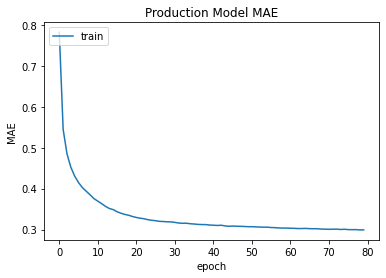

In [ ]:
plt.plot(history.history['mae'])
#plt.plot(history.history['val_mae'])
plt.title('Production Model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
#model building
epochs = 80
batch_size = 64

t0 = datetime.now()
history = model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scale, y_val)) #callbacks=[early_stopping]

Epoch 1/125
2594/2594 [==============================] - 11s 3ms/step - loss: 2.3645 - mae: 0.9948 - mse: 2.3645 - val_loss: 0.7123 - val_mae: 0.6429 - val_mse: 0.7123
Epoch 2/125
2594/2594 [==============================] - 8s 3ms/step - loss: 0.7748 - mae: 0.5816 - mse: 0.7748 - val_loss: 0.6677 - val_mae: 0.6061 - val_mse: 0.6677
Epoch 3/125
2594/2594 [==============================] - 8s 3ms/step - loss: 0.6284 - mae: 0.5095 - mse: 0.6284 - val_loss: 0.6608 - val_mae: 0.5834 - val_mse: 0.6608
Epoch 4/125
2594/2594 [==============================] - 8s 3ms/step - loss: 0.5593 - mae: 0.4690 - mse: 0.5593 - val_loss: 0.5609 - val_mae: 0.5151 - val_mse: 0.5609
Epoch 5/125
2594/2594 [==============================] - 7s 3ms/step - loss: 0.5219 - mae: 0.4457 - mse: 0.5219 - val_loss: 0.5028 - val_mae: 0.4562 - val_mse: 0.5028
Epoch 6/125
2594/2594 [==============================] - 8s 3ms/step - loss: 0.4970 - mae: 0.4294 - mse: 0.4970 - val_loss: 0.5269 - val_mae: 0.4638 - val_mse: 0.52

In [ ]:
t1 = datetime.now()
print("Time elapsed: ", t1-t0)

Time elapsed:  0:15:44.748290


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


In [ ]:
history.history['val_mae'][-1]

0.315784752368927

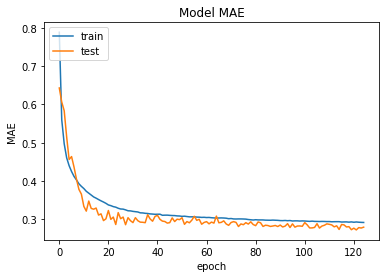

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history.history['mae'][19] - history.history['mae'][99]

0.21533489227294922

In [ ]:
history.history['val_mae'][19] - history.history['val_mae'][99]

0.24831998348236084

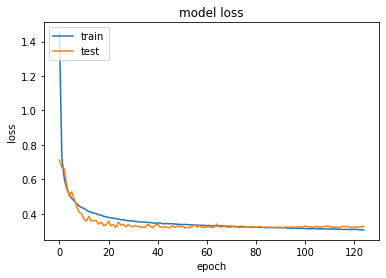

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history.history['loss'][19]-history.history['loss'][99]

0.40117329359054565

In [ ]:
history.history['val_loss'][19]-history.history['val_loss'][99]

0.3999191224575043

In [ ]:
y_pred = model.predict(X_test_scale)

In [ ]:
r2 = r2_score(y_test, y_pred)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R2: ", r2)
print("Adjusted R2: ", 1- (((1-r2)*(X_test_scale.shape[0]-1))/(X_test_scale.shape[0] - X_test_scale.shape[1] -1) ) )
#print("explained variance: ", explained_variance_score(y_test, y_pred))
#https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/adjusted-r2/

MSE:  0.3295806011566743
RMSE:  0.5740911087594671
MAE:  0.2786446773861854
R2:  0.8708672051783167
Adjusted R2:  0.8683088001680843


# production test

In [ ]:
y_pred = model.predict(X_scaled)

r2 = r2_score(y, y_pred)
print("MSE: ", mean_squared_error(y, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y, y_pred)))
print("MAE: ", mean_absolute_error(y, y_pred))
print("R2: ", r2)
#print("Adjusted R2: ", 1- (((1-r2)*(X_test_scale.shape[0]-1))/(X_test_scale.shape[0] - X_test_scale.shape[1] -1) ) )
#print("explained variance: ", explained_variance_score(y_test, y_pred))
#https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/adjusted-r2/

MSE:  0.2871032273899305
RMSE:  0.5358201446287089
MAE:  0.27368363461174594
R2:  0.8873141131177991


In [ ]:
X_test_scale.shape

(20745, 50)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              404000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 6000)              6006000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 6000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 3000)              18003000  
_________________________________________________________________
dropout_8 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [ ]:
model_num = 1

In [ ]:
model_name = "issue_7_support_score_predictor_v" + str(model_num) + ".h5"
model_output_dir = os.path.join(gdrive_dir, "My Drive", "homeless coalition", 'trust fund campaign', "neural network models", "support models")
model.save(os.path.join(model_output_dir, model_name))

In [ ]:
model_name

'issue_7_support_score_predictor_v1.h5'

# Load the best model, make sure we're getting the same values as before

In [ ]:
model_name = 'issue_7_support_score_predictor_v1.h5'
model = load_model(os.path.join(gdrive_dir, "My Drive", "homeless coalition", 'trust fund campaign', "neural network models", "support models", "support_score_v3.h5"))

In [ ]:
y_pred = model.predict(X_test_scale)

In [ ]:
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))


MSE:  0.0012500386467533084
RMSE:  0.03535588560272969
MAE:  0.020431878852010667
R2:  0.8663818258449854


# Predict values for the whole voter file

In [ ]:
features_path = os.path.join(gdrive_dir, "My Drive", "homeless coalition", 'trust fund campaign', 'neural network models', 'support models', 'issue_7_prediction_features.csv')

prediction_features = pd.read_csv(features_path)

In [ ]:
prediction_features.head()

,ACTIVE,D,G,L,R,390610002001,390610007001,390610007002,390610007003,390610009001,390610009002,390610009003,390610010001,390610010002,390610010003,390610011001,390610016001,390610016002,390610017001,390610017002,390610018001,390610018002,390610019001,390610019002,390610020001,390610020002,390610022001,390610022002,390610022003,390610023001,390610025001,390610025002,390610026001,390610026002,390610026003,390610027001,390610028001,390610028002,390610029001,390610029002,390610029003,390610029011,390610030001,390610030002,390610030003,390610032001,390610033001,390610033002,390610036001,390610036002,390610037001,390610037002,390610038001,390610038002,390610038003,390610039001,390610039002,390610039003,390610040001,390610040002,390610041001,390610041002,390610042001,390610042002,390610045001,390610046021,390610046022,390610046023,390610046031,390610046032,390610046041,390610046042,390610046043,390610046051,390610046052,390610047011,390610047012,390610047021,390610047031,390610047032,390610047033,390610048001,390610048002,390610048003,390610049001,390610049002,390610049003,390610049004,390610049005,390610050001,390610050002,390610050003,390610050004,390610050005,390610051001,390610051002,390610052001,390610052002,390610052003,390610053011,390610053012,390610053013,390610053021,390610053022,390610053023,390610054001,390610055001,390610055002,390610055003,390610055004,390610056001,390610056002,390610056003,390610056004,390610056005,390610057011,390610057012,390610057013,390610057021,390610057022,390610057023,390610057024,390610058001,390610058002,390610058003,390610058004,390610058005,390610059001,390610060001,390610060002,390610060003,390610060004,390610060005,390610061001,390610061002,390610063001,390610063002,390610063003,390610063004,390610063005,390610064001,390610064002,390610064003,390610064004,390610065001,390610065002,390610065003,390610065004,390610065005,390610065006,390610065011,390610065021,390610065022,390610065023,390610066001,390610066002,390610068001,390610068002,390610068003,390610068004,390610069001,390610069002,390610069003,390610070001,390610070002,390610070003,390610071001,390610071002,390610071003,390610072001,390610072002,390610073001,390610073002,390610074001,390610074002,390610074003,390610075001,390610075002,390610077001,390610077002,390610078001,390610078002,390610078003,390610079001,390610079002,390610080001,390610080002,390610080003,390610081001,390610081002,390610082011,390610082012,390610082013,390610082021,390610082022,390610082023,390610083001,390610083002,390610083003,390610084001,390610084002,390610085011,390610085012,390610085013,390610085021,390610086011,390610086012,390610086013,390610086014,390610088001,390610088002,390610092001,390610092002,390610092003,390610093001,390610093002,390610093003,390610093004,390610094001,390610095001,390610095002,390610095003,390610096001,390610096002,390610096003,390610096004,390610097001,390610097002,390610097003,390610097004,390610097005,390610098001,390610099011,390610099012,390610099013,390610099021,390610099022,390610100021,390610100022,390610100023,390610100024,390610100025,390610100031,390610100032,390610100033,390610100041,390610100042,390610100043,390610100044,390610100051,390610101001,390610101002,390610101003,390610102011,390610102012,390610102013,390610102014,390610102015,390610102021,390610102022,390610102023,390610103001,390610103002,390610104001,390610104002,390610105001,390610105002,390610106001,390610107001,390610107002,390610108001,390610109001,390610109002,390610110001,390610110002,390610111001,390610111002,390610205052,390610207014,390610207052,390610207412,390610207612,390610207615,390610208111,390610208114,390610209013,390610209022,390610209023,390610209024,390610209025,390610210011,390610210021,390610212021,390610212023,390610214011,390610214013,390610214014,390610214214,390610214221,390610215082,390610215091,390610215096,390610216021,390610216022,390610216023,390610217022,390610218011,390610218021,390610219001,390610221026,390610222002,390610

In [ ]:
# get rid of columns that weren't in the training data
data_dir = os.path.join(gdrive_dir, "My Drive", "homeless coalition", 'trust fund campaign')
ft_filename = "issue 7 features and target.csv"
features_and_target = pd.read_csv(os.path.join(data_dir, ft_filename))

missing_vals = []

for col in prediction_features.columns:
    if col not in features_and_target.columns:
        missing_vals.append(col)

missing_vals

['390610029022',
 '390610244012',
 '390610264005',
 '390610277001',
 '390610277003',
 '390610277004']

In [ ]:
prediction_features.drop(columns = missing_vals, inplace=True)

In [ ]:
missing_census_indices = prediction_features.index[prediction_features['pct_under_30k'].isna()]

In [ ]:
missing_census_indices.shape

(8369,)

In [ ]:
prediction_features[['AGE', 'pct_renters']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223404 entries, 0 to 223468
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   AGE          223404 non-null  float64
 1   pct_renters  215035 non-null  float64
dtypes: float64(2)
memory usage: 5.1 MB


In [ ]:
prediction_features.loc[missing_census_indices, 'pct_under_30k'] = prediction_features['pct_under_30k'].mean()
prediction_features.loc[missing_census_indices, 'pct_post_grad'] = prediction_features['pct_post_grad'].mean()
prediction_features.loc[missing_census_indices, 'pct_renters'] = prediction_features['pct_renters'].mean()


In [ ]:
scaler = StandardScaler()

scaler.fit(prediction_features)
X = scaler.transform(prediction_features)

In [ ]:
x_sum = np.sum(X)
np.isnan(x_sum)

False

In [ ]:
model = load_model(os.path.join(gdrive_dir, "My Drive", "homeless coalition", 'trust fund campaign', "neural network models", "support models", "support_score_v3.h5"))

In [ ]:
y = model.predict(X)

In [ ]:
y.shape

(223404, 1)

In [ ]:
type(y)

numpy.ndarray

In [ ]:
voter_file.shape

(223404, 130)

In [ ]:
data_dir = os.path.join(gdrive_dir, "My Drive", "homeless coalition", 'trust fund campaign')

filename = 'voter file features collected.csv'

voter_file = pd.read_csv(os.path.join(data_dir, filename))

In [ ]:
y_max = np.amax(y)

In [ ]:
y_min = np.amin(y)

In [ ]:
voter_file['raw_support_score'] = y

In [ ]:
voter_file['scaled_support_score'] = voter_file['raw_support_score'].apply(lambda x: (x - y_min)/(y_max - y_min))

In [ ]:
voter_file[['raw_support_score', 'scaled_support_score']].describe()

,raw_support_score,scaled_support_score
count,223404.000000,223404.000000
mean,2.937506,0.253542
std,1.436663,0.159267
min,0.650516,0.000000
25%,1.938788,0.142816
50%,2.518338,0.207064
75%,3.548889,0.321309
max,9.671039,1.000000


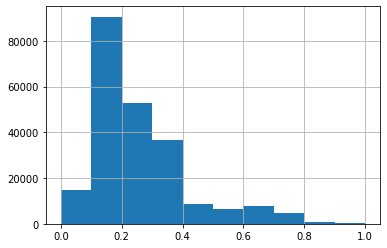

In [ ]:
voter_file['scaled_support_score'].hist()

In [ ]:
40000/len(voter_file)

0.17904782367370325

In [ ]:
voter_file['scaled_support_score'].quantile(.8)

0.34021934717483493

In [ ]:
voter_file['scaled_support_score'].quantile(.9)

0.45938892896955025

In [ ]:
voter_file.head(2)

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,PARTY_AFFILIATION,RESIDENTIAL_ADDRESS1_voter,RESIDENTIAL_SECONDARY_ADDR,RESIDENTIAL_CITY_voter,RESIDENTIAL_STATE_voter,RESIDENTIAL_ZIP_voter,RESIDENTIAL_ZIP_PLUS4,RESIDENTIAL_COUNTRY,RESIDENTIAL_POSTALCODE,tigerlineid,side,tract,block,lat,lon,MAILING_ADDRESS1,MAILING_SECONDARY_ADDRESS,MAILING_CITY,MAILING_STATE,MAILING_ZIP,MAILING_ZIP_PLUS4,MAILING_COUNTRY,MAILING_POSTAL_CODE,CAREER_CENTER,CITY,CITY_SCHOOL_DISTRICT,COUNTY_COURT_DISTRICT,CONGRESSIONAL_DISTRICT,COURT_OF_APPEALS,EDU_SERVICE_CENTER_DISTRICT,EXEMPTED_VILL_SCHOOL_DISTRICT,LIBRARY,LOCAL_SCHOOL_DISTRICT,MUNICIPAL_COURT_DISTRICT,PRECINCT_NAME,PRECINCT_CODE,STATE_BOARD_OF_EDUCATION,STATE_REPRESENTATIVE_DISTRICT,STATE_SENATE_DISTRICT,TOWNSHIP,VILLAGE,WARD,PRIMARY-03/07/2000,GENERAL-11/07/2000,SPECIAL-05/08/2001,GENERAL-11/06/2001,PRIMARY-05/07/2002,GENERAL-11/05/2002,SPECIAL-05/06/2003,GENERAL-11/04/2003,PRIMARY-03/02/2004,GENERAL-11/02/2004,SPECIAL-02/08/2005,PRIMARY-05/03/2005,PRIMARY-09/13/2005,GENERAL-11/08/2005,SPECIAL-02/07/2006,PRIMARY-05/02/2006,GENERAL-11/07/2006,PRIMARY-05/08/2007,PRIMARY-09/11/2007,GENERAL-11/06/2007,PRIMARY-11/06/2007,GENERAL-12/11/2007,PRIMARY-03/04/2008,PRIMARY-10/14/2008,GENERAL-11/04/2008,GENERAL-11/18/2008,PRIMARY-05/05/2009,PRIMARY-09/08/2009,PRIMARY-09/15/2009,PRIMARY-09/29/2009,GENERAL-11/03/2009,PRIMARY-05/04/2010,PRIMARY-07/13/2010,PRIMARY-09/07/2010,GENERAL-11/02/2010,PRIMARY-05/03/2011,PRIMARY-09/13/2011,GENERAL-11/08/2011,PRIMARY-03/06/2012,GENERAL-11/06/2012,PRIMARY-05/07/2013,PRIMARY-09/10/2013,PRIMARY-10/01/2013,GENERAL-11/05/2013,PRIMARY-05/06/2014,GENERAL-11/04/2014,PRIMARY-05/05/2015,PRIMARY-09/15/2015,GENERAL-11/03/2015,PRIMARY-03/15/2016,GENERAL-06/07/2016,PRIMARY-09/13/2016,GENERAL-11/08/2016,PRIMARY-05/02/2017,PRIMARY-09/12/2017,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019,PRIMARY-03/17/2020,GENERAL-11/03/2020,block_str,fips_bg,census_block_number,race_name,GENDER,pct_under_30k,pct_post_grad,pct_renters,is_apartment,FIRST_ELIGIBLE_ELECTION,AGE,YEARS_REGISTERED,PCT_TOTAL_BALLOTS_CAST,PCT_PRIMARY_BALLOTS_CAST,raw_support_score,scaled_support_score
0,OH0023466264,31,1884306,POKORNY,MICHAEL,F,NaN,1987-07-19,2015-12-22,ACTIVE,NaN,526 LIBERTY HILL,NaN,CINCINNATI,OH,45202,NaN,NaN,NaN,103953039.0,L,1800.0,1017.0,39.112280,-84.505615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 10-A,31-AGY,4,32,9,NaN,NaN,CINTI WARD 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,X,1017,390610018001,390610018001017,white,male,0.124260,0.272593,0.568047,0,PRIMARY-03/15/2016,33.793292,5.284052,0.2,0.0,3.647926,0.332288
1,OH0023768498,31,1907972,SCARBOROUGH,ANTHONY,M,NaN,1968-08-24,2016-06-27,CONFIRMATION,NaN,1022 YALE AVE,NaN,CINCINNATI,OH,45206,NaN,NaN,NaN,103970492.0,L,3700.0,1005.0,39.128967,-84.487260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 9-D,31-AGQ,4,31,9,NaN,NaN,CINTI WARD 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1005,390610037001,390610037001005,white,male,0.413636,0.061789,0.636364,0,PRIMARY-09/13/2016,52.692676,4.769336,0.0,0.0,3.789315,0.347962


In [ ]:
output_cols = ['SOS_VOTERID', 'LAST_NAME', 'FIRST_NAME', 'MIDDLE_NAME', 'SUFFIX', 'DATE_OF_BIRTH', 'REGISTRATION_DATE', 'VOTER_STATUS', 'PARTY_AFFILIATION', 'RESIDENTIAL_ADDRESS1_voter', 'RESIDENTIAL_SECONDARY_ADDR', 'RESIDENTIAL_CITY_voter', 'RESIDENTIAL_STATE_voter', 'RESIDENTIAL_ZIP_voter', 'RESIDENTIAL_ZIP_PLUS4', 'tigerlineid', 'side', 'tract', 'block', 'lat', 'lon', 'PRECINCT_NAME', 'WARD', 'fips_bg', 'census_block_number', 'race_name', 'GENDER', 'pct_under_30k', 'pct_post_grad', 'pct_renters', 'is_apartment', 'raw_support_score', 'scaled_support_score']

In [ ]:
support_score_path = os.path.join(gdrive_dir, "My Drive", "homeless coalition", 'trust fund campaign', 'neural network models', 'support models')
support_file_name = "issue 7 support scores yes vs no.csv"
voter_file[output_cols].to_csv(os.path.join(support_score_path, support_file_name), index=False)